<a href="https://colab.research.google.com/github/jgprogramming/GANCoder/blob/master/GanCoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
from tqdm import tqdm
import numpy as np

class Encoder:
  
  session = None
  message_size = None
  batch_size = None
  noise_multiplier = None
  
  D_optim = None
  G_optim = None
  DEC_optim = None
  
  x = None
  message = None
  isTrain = None
  z = None
  
  gen = None
  gen_binary = None
  dec = None
  
  def __init__(self, session, message_size=60, batch_size = 512, noise_multiplier=1):
    
    self.session = session
    self.message_size = message_size
    self.batch_size = batch_size
    self.noise_multiplier = noise_multiplier
    lr = 0.001
    
    # placeholders
    x = tf.placeholder(tf.float32, shape=(None, 32, 32, 1))
    # noise
    z = tf.placeholder(tf.float32, shape=(None, self.message_size*self.noise_multiplier, 1, 1))
    
    # message
    message = tf.placeholder(tf.float32, shape=(None, self.message_size, 1, 1))
    isTrain = tf.placeholder(dtype=tf.bool)

    self.x = x
    self.z = z
    self.message = message
    self.isTrain = isTrain
    
    # generator - fake
    bin_G_z, G_z = self.generator(message, z, isTrain)
    DEC_g = self.decoder(bin_G_z, isTrain)

    self.gen = G_z
    self.gen_binary = bin_G_z
    self.dec = DEC_g
    
    # discriminator - real
    D_real, D_real_logits = self.discriminator(x, isTrain)

    # discriminator - fake
    D_fake, D_fake_logits = self.discriminator(G_z, isTrain, reuse=True)

    # loses
    # disc
    D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, labels=tf.ones([batch_size, 1, 1, 1])))
    D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.zeros([batch_size, 1, 1, 1])))
    D_loss = D_loss_real + D_loss_fake

    # gen
    DEC_loss = tf.losses.mean_squared_error(DEC_g, message)
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.ones([batch_size, 1, 1, 1])))

    # trainable variables
    T_vars = tf.trainable_variables()
    D_vars = [var for var in T_vars if var.name.startswith('discriminator')]
    G_vars = [var for var in T_vars if var.name.startswith('generator') or var.name.startswith('decoder')]

    # optimizers
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        self.D_optim = tf.train.AdamOptimizer(lr, beta1=0.4).minimize(D_loss, var_list=D_vars)
        self.G_optim = tf.train.AdamOptimizer(lr, beta1=0.4).minimize(G_loss, var_list=G_vars)
        self.DEC_optim = tf.train.AdamOptimizer(lr, beta1=0.4).minimize(DEC_loss, var_list=G_vars)
  
  def train(self, train_data, epochs=1):
    sess = self.session
    init = tf.global_variables_initializer()
    sess.run(init)
    for epoch in tqdm(range(epochs)):
      for iter in range(len(train_data) // self.batch_size):
          x_ = train_data[iter*self.batch_size:(iter+1)*self.batch_size]
          message_ = (np.random.randint(2, size=[self.batch_size, self.message_size, 1, 1]) - 0.5) * 2
          z_ = np.random.normal(0, 1, (self.batch_size, self.message_size*self.noise_multiplier, 1, 1))
          
          # discriminator
          sess.run([self.D_optim], {self.x: x_, self.message: message_, self.z: z_, self.isTrain: True})

          # generator
          message_ = (np.random.randint(2, size=[self.batch_size, self.message_size, 1, 1]) - 0.5) * 2
          z_ = np.random.normal(0, 1, (self.batch_size, self.message_size*self.noise_multiplier, 1, 1))
          sess.run([self.G_optim], {self.x: x_, self.message: message_, self.z: z_, self.isTrain: True})

          
          # encoder
          message_ = (np.random.randint(2, size=[self.batch_size, self.message_size, 1, 1]) - 0.5) * 2
          z_ = np.random.normal(0, 1, (self.batch_size, self.message_size*self.noise_multiplier, 1, 1))
          sess.run([self.DEC_optim], {self.x: x_, self.message: message_, self.z: z_, self.isTrain: True})

  def encode(self, message, tries=20):
    sess = self.session
    
    message = np.repeat(message, tries, axis=0)
    z_ = np.random.normal(0, 1, (np.shape(message)[0], self.message_size*self.noise_multiplier, 1, 1))
    gen, binary = sess.run([self.gen, self.gen_binary ], { self.message: message,self.z: z_, self.isTrain: False})
    
    decoded = self.decode(binary)
    
    message = np.reshape(message, [-1, self.message_size])
    decoded = np.reshape(decoded, [-1, self.message_size])
    try:
      index = np.where(np.all(np.equal(message, decoded), axis = 1)==True)[0][0]
      return [gen[index]], [binary[index]], [True]
    except:
      return [gen[0]], [binary[0]], [False]
    
    
  def encodeString(self, string, tries=1000):
    
    images = []
    binaries = []
    bits = tobits(string)
    chunks = int(np.ceil(len(bits) / self.message_size))    
    bits = np.pad(bits, (0, self.message_size * chunks) , 'constant', constant_values=(0, 0))
    
    for i in range(chunks):
      encode_chunk = bits[self.message_size*i:self.message_size*(i+1)]
      encode_chunk = (encode_chunk * 2) - 1
      encode_chunk = np.reshape(encode_chunk, [1, self.message_size, 1, 1])
      found = False
      while not found:
        image_, binary_, f = self.encode(encode_chunk, tries=tries)
        image_ = np.reshape(image_[0], [32, 32])
        if f[0]:
          found = f[0]
          images += [image_]
          binaries += [binary_]
          print("chunk " + str(i+1) + "/" + str(chunks) + " encoded")
        else:
          print("encoding failed, retrying chunk " + str(i+1))
    return images, binaries
  
  def decodeString(self, images):
    codes = []
    for image_ in images:
      image = np.reshape(image_, [1, 32, 32, 1])
      code = np.reshape(self.decode(image), [self.message_size])
      codes.extend(code)
      
    codes = [int((i+1)/2) for i in codes]
    return frombits(codes)
    
    
  def decode(self, image):
    sess = self.session
    x = tf.placeholder(tf.float32, shape=(None, 32, 32, 1))
    
    return sess.run(self.decoder(x, False, True), {x: image})
    
  def save(self, filename):
    sess = self.session
    saver = tf.train.Saver()
    saver.save(sess, filename)
    
  def load(self, filename):
    sess = self.session
    saver = tf.train.Saver()
    saver.restore(sess, tf.train.latest_checkpoint(filename))
    
  def generator(self, message, noise, isTrain=True, reuse=False):
      with tf.variable_scope('generator', reuse=reuse):
          x = tf.reshape(tf.contrib.layers.flatten(tf.concat([tf.cast(message, tf.float32), tf.cast(noise, tf.float32)],1)), [-1, 1, 1, self.message_size + self.message_size*self.noise_multiplier])
          
          conv1 = tf.layers.conv2d_transpose(x, 512, [4, 4], strides=(2, 2), padding='valid')
          lrelu1 = tf.nn.leaky_relu(tf.layers.batch_normalization(conv1, training=isTrain))

          conv2 = tf.layers.conv2d_transpose(lrelu1, 256, [4, 4], strides=(2, 2), padding='same')
          lrelu2 = tf.nn.leaky_relu(tf.layers.batch_normalization(conv2, training=isTrain))

          conv3 = tf.layers.conv2d_transpose(lrelu2, 128, [4, 4], strides=(2, 2), padding='same')
          lrelu3 = tf.nn.leaky_relu(tf.layers.batch_normalization(conv3, training=isTrain))

          conv4 = tf.layers.conv2d_transpose(lrelu3, 1, [4, 4], strides=(2, 2), padding='same')
          out = tf.nn.tanh(conv4)
          
          return binarize(out), out
    
  def decoder(self, input_batch, isTrain=True, reuse=False):
      with tf.variable_scope('decoder', reuse=reuse):
          conv1 = tf.layers.conv2d(input_batch, 128, [4, 4], strides=(2, 2), padding='same')
          lrelu1 = tf.nn.leaky_relu(tf.layers.batch_normalization(conv1, training=isTrain))

          conv2 = tf.layers.conv2d(lrelu1, 256, [4, 4], strides=(2, 2), padding='same')
          lrelu2 = tf.nn.leaky_relu(tf.layers.batch_normalization(conv2, training=isTrain))

          conv3 = tf.layers.conv2d(lrelu2, 512, [4, 4], strides=(2, 2), padding='same')
          lrelu3 = tf.nn.leaky_relu(tf.layers.batch_normalization(conv3, training=isTrain))

          dense1 = tf.layers.dense(tf.contrib.layers.flatten(lrelu3), self.message_size, activation=tf.nn.leaky_relu)    
          out = tf.nn.tanh(dense1)
          return binarize(tf.reshape(out, shape=[-1, self.message_size, 1, 1]))
    
  def discriminator(self, x, isTrain=True, reuse=False):
      with tf.variable_scope('discriminator', reuse=reuse):
          conv1 = tf.layers.conv2d(x, 128, [4, 4], strides=(2, 2), padding='same')
          lrelu1 = tf.nn.leaky_relu(tf.layers.batch_normalization(conv1, training=isTrain))

          conv2 = tf.layers.conv2d(lrelu1, 256, [4, 4], strides=(2, 2), padding='same')
          lrelu2 = tf.nn.leaky_relu(tf.layers.batch_normalization(conv2, training=isTrain))

          conv3 = tf.layers.conv2d(lrelu2, 512, [4, 4], strides=(2, 2), padding='same')
          lrelu3 = tf.nn.leaky_relu(tf.layers.batch_normalization(conv3, training=isTrain))

          conv4 = tf.layers.conv2d(lrelu3, 1, [4, 4], strides=(1, 1), padding='valid')
          out = tf.nn.sigmoid(conv4)

          return out, conv4
    
def binarize(x):
    g = tf.get_default_graph()
    with g.gradient_override_map({"Sign": "Identity"}):
        return tf.sign(x)
      
def tobits(s):
    result = []
    for c in s:
        bits = bin(ord(c))[2:]
        bits = '00000000'[len(bits):] + bits
        result.extend([int(b) for b in bits])
    return result

def frombits(bits):
    chars = []
    for b in range(len(bits) // 8):
        byte = bits[b*8:(b+1)*8]
        chars.append(chr(int(''.join([str(bit) for bit in byte]), 2)))
    return ''.join(chars)

In [0]:
#colab
# google-drive-ocamlfuseのインストール
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# Colab用のAuth token作成
from google.colab import auth
auth.authenticate_user()

# Drive FUSE library用のcredential生成
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
# ! mkdir -p drive/saved_models/GanCoder/emnist-32x32-48/
# tf.reset_default_graph()
# session = tf.Session()
# encoder = Encoder(session, message_size=48, batch_size=256)
for i in range(4):
  encoder.train(train_data, epochs = 5)
  encoder.save("drive/saved_models/GanCoder/emnist-32x32-48/model")


  0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [0]:
tf.reset_default_graph()
session = tf.Session()
encoder = Encoder(session, message_size=32, noise_multiplier=1)
encoder.load('drive/saved_models/GanCoder/emnist-32x32-32')

INFO:tensorflow:Restoring parameters from drive/saved_models/GanCoder/emnist-32x32-32/model


In [0]:
imgs, bins = encoder.encodeString("www.google.commm", tries=1000)
print(encoder.decodeString(bins))

show_images(imgs)


chunk 1/4 encoded
chunk 2/4 encoded
chunk 3/4 encoded
chunk 4/4 encoded
www.google.commm


NameError: ignored

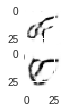

In [0]:
fig = plt.figure(figsize=(70, 50))  # width, height in inches

for i in range(len(imgs)):
    sub = fig.add_subplot(64, 1, i + 1)
    sub.imshow(imgs[i], interpolation='nearest')

True


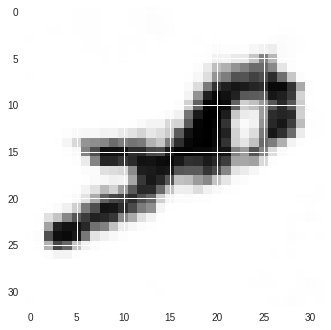

In [0]:
import numpy as np
import matplotlib.pyplot as plt
m_size = 32
message = (np.random.randint(2, size=[1, m_size, 1, 1]) - 0.5) * 2
imgs, bins, lossless = encoder.encode(message, tries=10000)
plt.imshow(np.reshape(imgs[0], [32, 32]))
print(lossless[0])

In [0]:
! wget -nc http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip
! unzip -o gzip.zip
! rm gzip/train-images-idx3-ubyte.gz gzip/train-labels-idx1-ubyte.gz
! mv gzip/emnist-balanced-train-images-idx3-ubyte.gz gzip/train-images-idx3-ubyte.gz
! mv gzip/emnist-balanced-train-labels-idx1-ubyte.gz gzip/train-labels-idx1-ubyte.gz
! ls -la gzip


import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

train_data = input_data.read_data_sets('mnist').train.images
train_data = np.reshape(train_data, [-1, 28, 28, 1])

input_data = tf.placeholder("float", [None, 28, 28, 1])
resize = tf.image.resize_images(
    input_data,
    [32, 32]
)

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    
    train_data =  sess.run(resize, feed_dict={input_data: train_data})
    train_data = (train_data - 0.5) * 2


--2018-06-03 18:04:53--  http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip
Resolving www.itl.nist.gov (www.itl.nist.gov)... 132.163.4.36, 2610:20:6b01:4::36
Connecting to www.itl.nist.gov (www.itl.nist.gov)|132.163.4.36|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip [following]
--2018-06-03 18:04:54--  https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip
Connecting to www.itl.nist.gov (www.itl.nist.gov)|132.163.4.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 561753746 (536M) [application/zip]
Saving to: ‘gzip.zip’

gzip.zip            100%[===================>] 535.73M  67.7MB/s    in 7.7s    

2018-06-03 18:05:02 (69.2 MB/s) - ‘gzip.zip’ saved [561753746/561753746]

Archive:  gzip.zip
  inflating: gzip/emnist-balanced-mapping.txt  
  inflating: gzip/emnist-balanced-test-images-idx3-ubyte.gz  
 extracting: gzip/emnist-balanced-test-labels-id

Extracting gzip/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting gzip/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting gzip/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


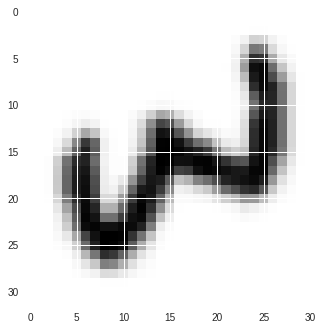

In [0]:
plt.imshow(np.reshape(train_data[0], [32, 32]))
# train_data = train_data[:10000]

In [0]:
!pip install matplotlib tqdm PyDrive

    100% |████████████████████████████████| 51kB 3.6MB/s 
    100% |████████████████████████████████| 993kB 11.4MB/s 
  Running setup.py bdist_wheel for PyDrive ... - \ done
  Stored in directory: /content/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


In [0]:
! ls -la Drive

^C


In [0]:
import pickle
import numpy as np

with open('drive/data_sets/caltech_32x32.pkl', 'rb') as f:
    train_data = pickle.load(f)
train_data = (np.array(train_data) - 0.5) * 2

In [0]:

frombits(tobits("test"))

'test'

In [0]:
a = [-1.0, 1.0]
[int((i+1)/2) for i in a]

[0, 1]

In [0]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()